In [1]:
from collections import OrderedDict
from google.colab import drive
import matplotlib
matplotlib.rcParams['figure.figsize'] = [5, 4]
matplotlib.rcParams['font.size'] = 10
import matplotlib.ticker as mticker
from matplotlib.ticker import PercentFormatter, ScalarFormatter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.autograd import grad, Variable
from torch.nn.functional import softmax
from torch.utils.data import DataLoader, Dataset

In [2]:
!pip install pylogit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.4/151.4 kB 3.6 MB/s eta 0:00:00


**Note:** The `pylogit` library needs to be installed manually for Colab. To solve the error `cannot import name 'Iterable' from 'collections' (/usr/lib/python3.10/collections/__init__.py)`, we can replace `collections` with `collections.abc` in the file `/usr/local/lib/python3.10/dist-packages/pylogit/choice_tools.py`.

In [3]:
file_path = '/usr/local/lib/python3.10/dist-packages/pylogit/choice_tools.py'
with open(file_path, 'r') as file:
    lines = file.readlines()

lines[14] = 'from collections.abc import Iterable\n'

with open(file_path, 'w') as file:
    file.writelines(lines)

In [4]:
import pylogit as pl

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


# CMAP Dataset

## Data import

In [6]:
size = 1500
var, alt = 'auto_cost', 0
path = '/content/drive/My Drive'
data1 = pd.read_csv(f'{path}/CMAP/chicago_processed.csv', index_col=0).sample(size, random_state=30)

In [7]:
data1['high_edu'] = data1['educ'].isin([5, 6]).astype(int)
data1['hhveh_1'] = (data1['hhveh'] == 1).astype(int)
data1['hhsize_1'] = (data1['hhsize'] == 1).astype(int)
data1['high_inc'] = (data1['hhinc'] > 7).astype(int)

data1 = data1[['age', 'male', 'high_edu', 'hhsize_1', 'hhsize', 'hhveh', 'hhveh_1', 'high_inc', 'auto_time', 'auto_cost', 'train_time',
               'train_cost', 'active_time', 'mode']]

In [8]:
data = pd.DataFrame(StandardScaler().fit_transform(data1), columns=data1.columns, index=data1.index)
data['mode'] = data1['mode']

In [9]:
train_size = 800
val_size = 200
test_size = size - train_size - val_size

data_train, data_remain = data[:train_size], data[train_size:]
data_val, data_test = data_remain[:val_size], data_remain[val_size:]

## Data processing
2. Build a dataframe with average values, except for the visualized variable,
3. Develop a function to build dataframes for model regularity calculation, and
4. Load the data for training, validation, and testing.

In [10]:
upper, lower = data[var].max(), data[var].min()
prb_size = 201
data_prb = pd.DataFrame(np.zeros((prb_size, len(data.columns))), columns=data.columns)
data_prb[var] = np.linspace(lower, upper, prb_size)

In [11]:
num_var = data.columns.get_loc(var)

def gen_reg_df(data, upper, lower):
    'Function to build a dataset for regularity calculation'
    data_reg = data.copy()
    data_reg = data_reg.loc[data_reg.index.repeat(2)]
    data_reg.iloc[np.arange(1, len(data_reg), 2), num_var] += (upper - lower) / 200
    return data_reg

In [12]:
class Load(Dataset):
    'Class to load the datasets for modeling'
    def __init__(self, data):
        x_set = data.drop(columns='mode')
        y_set = data['mode']
        self.X = Variable(torch.tensor(x_set.values).float(), requires_grad=True)
        self.y = torch.tensor(y_set.values)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return len(self.X)

In [13]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

train_loader = DataLoader(Load(data_train), batch_size=train_size//10, worker_init_fn=seed_worker, generator=g)
val_loader = DataLoader(Load(data_val), batch_size=val_size, worker_init_fn=seed_worker, generator=g)
test_loader = DataLoader(Load(data_test), batch_size=test_size, worker_init_fn=seed_worker, generator=g)

# Datasets for model analysis
prb_loader = DataLoader(Load(data_prb), batch_size=prb_size, worker_init_fn=seed_worker, generator=g)
train_reg_loader = DataLoader(Load(gen_reg_df(data_train, upper, lower)), batch_size=2*train_size, worker_init_fn=seed_worker, generator=g)
val_reg_loader = DataLoader(Load(gen_reg_df(data_val, upper, lower)), batch_size=2*val_size, worker_init_fn=seed_worker, generator=g)
test_reg_loader = DataLoader(Load(gen_reg_df(data_test, upper, lower)), batch_size=2*test_size, worker_init_fn=seed_worker, generator=g)

## True market shares

In [14]:
l_alt = ['Auto', 'Train', 'Active']

def true_share(df):
    'Function to calculate the true market shares'
    y = df['mode'].replace(0, l_alt[0]).replace(1, l_alt[1]).replace(2, l_alt[2])
    return y.value_counts(normalize=True).round(3)[l_alt]

In [15]:
# Training set
true_share(data_train)

mode
Auto      0.684
Train     0.109
Active    0.208
Name: proportion, dtype: float64

In [16]:
# Validation set
true_share(data_val)

mode
Auto      0.680
Train     0.105
Active    0.215
Name: proportion, dtype: float64

In [17]:
# Test set
true_share(data_test)

mode
Auto      0.666
Train     0.104
Active    0.230
Name: proportion, dtype: float64

# Random utility models (RUMs)
The RUMs are estimated based on unstandardized inputs and a data frame with wide format.

In [18]:
def convert(df):
    'Function for data format conversion'
    df = df.reset_index(names='obs_id', drop=True)
    for a in ['auto', 'train', 'active']:
        df[f'ava_{a}'] = 1
    # Individual-specific variables
    ind_vars = df.columns.tolist()[:8]
    # Alternative-specific variables
    alt_vars = {u'time': dict([(0, 'auto_time'), (1, 'train_time'), (2, 'active_time')]),
                u'cost': dict([(0, 'auto_cost'), (1, 'train_cost')])}
    # Availability variables
    ava_vars = {0: 'ava_auto', 1: 'ava_train', 2: 'ava_active'}
    # Observation ID column
    df['obs_id'] = np.arange(df.shape[0], dtype=int) + 1
    # Wide format -> long format
    df_lg = pl.convert_wide_to_long(df, ind_vars, alt_vars, ava_vars, 'obs_id', 'mode', 'alt_id')
    return df_lg

In [19]:
data1_train, data1_remain = data1[:train_size], data1[train_size:]
data1_val, data1_test = data1_remain[:val_size], data1_remain[val_size:]

In [20]:
data1_train_lg = convert(data1_train)
data1_train_lg

,obs_id,alt_id,mode,age,male,high_edu,hhsize_1,hhsize,hhveh,hhveh_1,high_inc,time,cost
0,1,0,0,37,0,1,0,2,0,0,1,5.333333,6.572333
1,1,1,0,37,0,1,0,2,0,0,1,10.000000,2.408333
2,1,2,1,37,0,1,0,2,0,0,1,7.733333,0.000000
3,2,0,1,30,0,0,0,5,2,0,0,3.800000,6.572333
4,2,1,0,30,0,0,0,5,2,0,0,17.450000,2.483333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,799,1,0,41,1,1,0,2,1,1,1,29.216667,2.616667
2396,799,2,1,41,1,1,0,2,1,1,1,18.816667,0.000000
2397,800,0,1,28,1,1,0,2,1,1,1,8.983333,5.019000
2398,800,1,0,28,1,1,0,2,1,1,1,34.166667,2.091667


## Multinomial logit (MNL)
Auto is set as the reference alternative for sociodemographics.

In [21]:
spec = OrderedDict()
name = OrderedDict()

# Alternative-specific constants
spec['intercept'] = [1, 2]
name['intercept'] = ['asc_train', 'asc_active']

# Individual-specific variables
spec['age'] = [1, 2]
name['age'] = ['age_train', 'age_active']
spec['male'] = [1, 2]
name['male'] = ['male_train', 'male_active']
spec['high_edu'] = [1, 2]
name['high_edu'] = ['high_edu_train', 'high_edu_active']
spec['hhsize'] = [1, 2]
name['hhsize'] = ['hhsize_train', 'hhsize_active']
spec['hhsize_1'] = [1, 2]
name['hhsize_1'] = ['hhsize_1_train', 'hhsize_1_active']
spec['hhveh'] = [1, 2]
name['hhveh'] = ['hhveh_train', 'hhveh_active']
spec['hhveh_1'] = [1, 2]
name['hhveh_1'] = ['hhveh_1_train', 'hhveh_1_active']
spec['high_inc'] = [1, 2]
name['high_inc'] = ['high_inc_train', 'high_inc_active']

# Alternative-specific variables
spec['time'] = [0, 1, 2]
name['time'] = ['time_auto', 'time_train', 'time_active']
spec['cost'] = [0, 1]
name['cost'] = ['cost_auto', 'cost_train']

In [22]:
mnl = pl.create_choice_model(data1_train_lg, alt_id_col='alt_id', obs_id_col='obs_id', choice_col='mode', specification=spec,
                             model_type='MNL', names=name)
mnl.fit_mle(np.zeros(23))
mnl.get_statsmodels_summary()

Log-likelihood at zero: -878.8898
Initial Log-likelihood: -878.8898
Estimation Time for Point Estimation: 0.18 seconds.
Final log-likelihood: -548.0558


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:565: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                        mode   No. Observations:                  800
Model:             Multinomial Logit Model   Df Residuals:                      777
Method:                                MLE   Df Model:                           23
Date:                     Wed, 26 Jun 2024   Pseudo R-squ.:                   0.376
Time:                             23:31:09   Pseudo R-bar-squ.:               0.350
AIC:                             1,142.112   Log-Likelihood:               -548.056
BIC:                             1,249.858   LL-Null:                      -878.890
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
asc_train          -1.2754      0.825     -1.546      0.122      -2.893       0.342
asc_active         -0.0524      0.565     -0.093      0.926      -1.159       1.054
age_train          -0.0324      0.011     -2.855      0.004      -0.055      -0.010
age_active         -0.0164      0.008     -1.960      0.050      -0.033   -9.31e-07
male_train          0.3878      0.253      1.530      0.126      -0.109       0.885
male_active         0.2720      0.197      1.377      0.168      -0.115       0.659
high_edu_train      0.6067      0.341      1.781      0.075      -0.061       1.274
high_edu_active     0.7654      0.284      2.694      0.007       0.209       1.322
hhsize_train       -0.2644      0.151     -1.754      0.079      -0.560       0.031
hhsize_active      -0.1994      0.117     -1.702      0.089      -0.429       0.030
hhsize_1_train     -0.6011      0.401     -1.498      0.134      -1.388       0.185
hhsize_1_active    -0.7452      0.316     -2.360      0.018      -1.364      -0.126
hhveh_train        -0.5574      0.173     -3.225      0.001      -0.896      -0.219
hhveh_active       -0.9642      0.158     -6.113      0.000      -1.273      -0.655
hhveh_1_train      -0.8281      0.267     -3.099      0.002      -1.352      -0.304
hhveh_1_active     -0.3971      0.206     -1.929      0.054      -0.801       0.006
high_inc_train      0.2224      0.319      0.698      0.485      -0.402       0.847
high_inc_active     0.7817      0.248      3.152      0.002       0.296       1.268
time_auto          -0.0538      0.021     -2.522      0.012      -0.096      -0.012
time_train         -0.0324      0.007     -4.416      0.000      -0.047      -0.018
time_active        -0.0339      0.005     -7.248      0.000      -0.043      -0.025
cost_auto          -0.1648      0.049     -3.345      0.001      -0.261      -0.068
cost_train          0.3632      0.256      1.418      0.156      -0.139       0.865
===================================================================================
"""

## Results

In [23]:
data1_val_lg = convert(data1_val)
data1_test_lg = convert(data1_test)

In [24]:
def dcm_performance(pred, df):
    'Function to calculate performance metrics for DCMs'
    prb = pred.reshape(len(df), 3)
    y = df['mode']
    y_pred = prb.argmax(1)
    ll = 0
    for i in range(len(df)):
        ll += np.log(prb[i, y.iloc[i]])
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    return [ll, acc, f1]

In [25]:
def print_metrics(met_train, met_val, met_test):
    'Function to print performance metrics'
    print(f'Training set:   LL = {met_train[0]:<6.1f} | acc = {met_train[1]:.1%} | F1 = {met_train[2]:.1%}')
    print(f'Validation set: LL = {met_val[0]:<6.1f} | acc = {met_val[1]:.1%} | F1 = {met_val[2]:.1%}')
    print(f'Test set:       LL = {met_test[0]:<6.1f} | acc = {met_test[1]:.1%} | F1 = {met_test[2]:.1%}')

In [26]:
met_train_mnl = dcm_performance(mnl.predict(data1_train_lg), data1_train)
met_val_mnl = dcm_performance(mnl.predict(data1_val_lg), data1_val)
met_test_mnl = dcm_performance(mnl.predict(data1_test_lg), data1_test)
print_metrics(met_train_mnl, met_val_mnl, met_test_mnl)

Training set:   LL = -548.1 | acc = 71.5% | F1 = 66.3%
Validation set: LL = -163.0 | acc = 70.0% | F1 = 65.4%
Test set:       LL = -380.2 | acc = 71.8% | F1 = 66.5%


In [27]:
upper1, lower1 = data1[var].max(), data1[var].min()
data1_prb = pd.DataFrame(np.tile(data1.mean(), (prb_size, 1)), columns=data1.columns)
data1_prb['mode'] = pd.Series([np.random.randint(0, 3) for i in range(prb_size)])
data1_prb[var] = np.linspace(lower1, upper1, prb_size)
data1_prb_lg = convert(data1_prb)

In [28]:
# A colorblind-friendly colormap
l_color = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']

def RUM_sub(l_prb, name):
    'Function to plot substitution patterns'
    for a in range(3):
        plt.plot(data1_prb[var], l_prb[:, a], color=l_color[a], label=l_alt[a])
    plt.legend(frameon=False)
    plt.xlabel(f'{var} ($)')
    plt.ylabel('Probability')

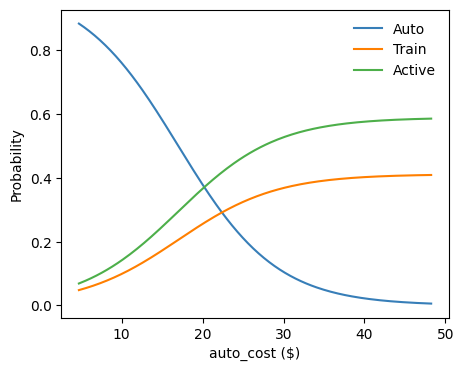

In [29]:
l_prb_MNL = mnl.predict(data1_prb_lg).reshape(len(data1_prb), 3)
RUM_sub(l_prb_MNL, 'MNL')

In [30]:
data1_train_reg = gen_reg_df(data1_train, upper1, lower1)
data1_val_reg = gen_reg_df(data1_val, upper1, lower1)
data1_test_reg = gen_reg_df(data1_test, upper1, lower1)

data1_train_reg_lg = convert(data1_train_reg)
data1_val_reg_lg = convert(data1_val_reg)
data1_test_reg_lg = convert(data1_test_reg)

In [31]:
eps = (lower1 - upper1) / 5e5

def cal_reg(l_prb_reg):
    'Function to calculate strong and weak regularities'
    diff = np.subtract(l_prb_reg[1::2], l_prb_reg[::2])
    reg_st = sum(diff < eps) / len(diff)
    reg_wk = sum(diff < -eps) / len(diff)
    print(f'Strong regularity = {reg_st:.3f}')
    print(f'Weak regularity   = {reg_wk:.3f}')
    return [reg_st, reg_wk]

In [32]:
print('Training set:')
prb_reg = mnl.predict(data1_train_reg_lg).reshape(2*train_size, 3)[:, alt]
met_train_mnl.extend(cal_reg(prb_reg))

print('-'*30, '\nValidation set:')
prb_reg = mnl.predict(data1_val_reg_lg).reshape(2*val_size, 3)[:, alt]
met_val_mnl.extend(cal_reg(prb_reg))

print('-'*30, '\nTest set:')
prb_reg = mnl.predict(data1_test_reg_lg).reshape(2*test_size, 3)[:, alt]
met_test_mnl.extend(cal_reg(prb_reg))

Training set:
Strong regularity = 0.999
Weak regularity   = 1.000
------------------------------ 
Validation set:
Strong regularity = 0.995
Weak regularity   = 1.000
------------------------------ 
Test set:
Strong regularity = 0.996
Weak regularity   = 1.000


In [33]:
l_index = ['Log-likelihood', 'Accuracy', 'F1 score', 'Strong regularity', 'Weak regularity']

results_train = pd.DataFrame({'MNL': met_train_mnl}, index=l_index)
results_val = pd.DataFrame({'MNL': met_val_mnl}, index=l_index)
results_test = pd.DataFrame({'MNL': met_test_mnl}, index=l_index)

results_train_std = pd.DataFrame({'MNL': 0}, index=l_index)
results_val_std = pd.DataFrame({'MNL': 0}, index=l_index)
results_test_std = pd.DataFrame({'MNL': 0}, index=l_index)

# Neural networks (NNs)

## Model structure

In [34]:
def cal_loss(model, X, y, GR, base, lambd, criterion):
    '''
    Function to regularize the loss function
    lambd: weight of GR -> (1-lambd) is the weight of loss
    base: indicator of regularizing the sum
    '''
    loss = criterion(model(X), y)
    # Utility GR
    if GR == 'UGR':
        utl = model(X)
        g1 = grad(utl[:, 0], X, torch.ones_like(utl[:, 0]), create_graph=True)[0][:, 8:10]
        g2 = grad(utl[:, 1], X, torch.ones_like(utl[:, 1]), create_graph=True)[0][:, 10:12]
        g3 = grad(utl[:, 2], X, torch.ones_like(utl[:, 2]), create_graph=True)[0][:, 12]
    # Probability GR
    elif GR == 'PGR':
        prb = softmax(model(X), dim=1)
        g1 = grad(prb[:, 0], X, torch.ones_like(prb[:, 0]), create_graph=True)[0][:, 8:10]
        g2 = grad(prb[:, 1], X, torch.ones_like(prb[:, 1]), create_graph=True)[0][:, 10:12]
        g3 = grad(prb[:, 2], X, torch.ones_like(prb[:, 2]), create_graph=True)[0][:, 12]
    # Loss GR
    elif GR == 'LGR':
        log_prb = torch.log(softmax(model(X), dim=1))
        g1 = grad(log_prb[:, 0]*(y==0), X, torch.ones_like(log_prb[:, 0]), create_graph=True)[0][:, 8:10]
        g2 = grad(log_prb[:, 1]*(y==1), X, torch.ones_like(log_prb[:, 0]), create_graph=True)[0][:, 10:12]
        g3 = grad(log_prb[:, 2]*(y==2), X, torch.ones_like(log_prb[:, 0]), create_graph=True)[0][:, 12]
    # Without GR
    else:
        return loss

    # Sum- vs. norm-GR
    if base == 'sum':
        reg = g1[g1 > 0].sum() + g2[g2 > 0].sum() + g3[g3 > 0].sum()
    else:
        reg = torch.pow(g1, 2).sum() + torch.pow(g2, 2).sum() + torch.pow(g3, 2).sum()
    return loss + lambd * reg

In [35]:
def train_loop(model, GR, base, lambd, optimizer, criterion):
    'Function for DNN training in each epoch'
    for X, y in train_loader:
        loss = cal_loss(model, X, y, GR, base, lambd, criterion)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss

In [36]:
def cal_metrics(model, criterion, loader):
    ll = 0
    y_true, y_pred = [], []
    for X, y in loader:
        pred = model(X)
        y_true.extend(y)
        loss = criterion(pred, y).item()
        ll -= loss * len(X)
        y_pred.extend(pred.argmax(1))
    f1 = f1_score(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)
    return ll, acc, f1, loss

In [37]:
def test(model, criterion):
    'Function for NN testing'
    model.eval()
    with torch.no_grad():
        # For loss, accuracy, and F1 score calculation
        met_train = cal_metrics(model, criterion, train_loader)
        met_val = cal_metrics(model, criterion, val_loader)
        met_test = cal_metrics(model, criterion, test_loader)

        # For probability calculation
        for X, _ in prb_loader:
            prb = softmax(model(X), dim=1).detach().numpy()

        # For regularity calculation
        for X_train, _ in train_reg_loader:
            prb_reg_train = softmax(model(X_train), dim=1)[:, alt].detach().numpy()
        for X_val, _ in val_reg_loader:
            prb_reg_val = softmax(model(X_val), dim=1)[:, alt].detach().numpy()
        for X_test, _ in test_reg_loader:
            prb_reg_test = softmax(model(X_test), dim=1)[:, alt].detach().numpy()
    return met_train, met_val, met_test, prb, prb_reg_train, prb_reg_val, prb_reg_test

In [38]:
def plot_loss(agg_loss):
    'Function to plot training and validation losses per epoch'
    for l_loss in agg_loss:
        plt.plot(range(1, len(l_loss[0])+1), l_loss[0], color=l_color[0], alpha=.2)
        plt.plot(range(1, len(l_loss[1])+1), l_loss[1], color=l_color[1], alpha=.2)
    plt.xlabel('Epoch')
    plt.ylabel('Cross-entropy loss')
    plt.show()

In [39]:
num_models = 10

def train(NN, num_epochs, GR, base, lambd):
    'Function for NN training'
    agg_loss, l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test = [[] for i in range(8)]
    for m in range(1, num_models+1):
        torch.manual_seed(m)
        model = NN()
        l_loss_train_epoch, l_loss_val_epoch = [], []
        optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0)
        criterion = nn.CrossEntropyLoss()
        for i in range(num_epochs):
            l_loss_train_epoch.append(train_loop(model, GR, base, lambd, optimizer, criterion).detach().numpy())
            model.eval()
            with torch.no_grad():
                l_loss_val_epoch.append(cal_metrics(model, criterion, val_loader)[3])
            model.train()
        agg_loss.append([l_loss_train_epoch, l_loss_val_epoch])
        met_train, met_val, met_test, prb, reg_train, reg_val, reg_test = test(model, criterion)
        [x.append(y) for x, y in zip([l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test],
                                     [met_train, met_val, met_test, prb, reg_train, reg_val, reg_test])]
        print(f'Model {m:<2}')
        print_metrics(met_train, met_val, met_test)
    plot_loss(agg_loss)
    return l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test

## Functions for analysis
We evaluate the models by:
- test loss, accuracy, and F1 score;
- strong and weak regularities.

In [40]:
def NN_agg(l_met):
    'Function to analyze aggregate NN performance'
    # Averages
    avg_ll = np.mean([r[0] for r in l_met])
    avg_acc = np.mean([r[1] for r in l_met])
    avg_f1 = np.mean([r[2] for r in l_met])
    # Standard deviations
    std_ll = np.std([r[0] for r in l_met])
    std_acc = np.std([r[1] for r in l_met])
    std_f1 = np.std([r[2] for r in l_met])
    print(f'Average log-likelihood = {avg_ll:.1f} ({std_ll:.1f})')
    print(f'Average accuracy       = {avg_acc:.1%} ({std_acc:.1%})')
    print(f'Average F1 score       = {avg_f1:.1%} ({std_f1:.1%})')
    return [avg_ll, avg_acc, avg_f1], [std_ll, std_acc, std_f1]

In [41]:
def NN_sub(l_prb, NN, base, GR, lambd):
    'Function to plot substitution patterns'
    for a in range(3):
        for p in l_prb[:, :, a]:
            plt.plot(data1_prb[var], p, color=l_color[a], alpha=.10)
        plt.plot(data1_prb[var], np.mean(l_prb[:, :, a], axis=0), color=l_color[a], label=f'$\varepsilon={l_alt[a]}$')
    plt.legend(frameon=False)
    plt.xlabel(f'{var} ($)')
    plt.ylabel('Probability')
    plt.show()

In [42]:
def NN_reg(l_prb_reg, eps):
    'Function to calculate strong and weak regularities for NNs'
    l_reg = []
    for prb_reg in l_prb_reg:
        diff_x = (upper1 - lower1) / 200
        diff = np.subtract(prb_reg[1::2], prb_reg[::2]) / diff_x
        l_reg.append(sum(diff < eps) / len(diff))
    avg_reg = np.mean(l_reg)
    std_reg = np.std(l_reg)
    print(f'epsilon = {eps:<7} | regularity = {avg_reg:.3f} ({std_reg:.3f})')
    return avg_reg, std_reg

In [43]:
l_eps = [1e-3, 1e-4, 0, -1e-4, -1e-3]
l_eps_labels = [r'$\varepsilon = 10^{-3}$', r'$\varepsilon = 10^{-4}$', r'$\varepsilon = 0$', r'$\varepsilon = -10^{-4}$',  r'$\varepsilon = -10^{-3}$']

def comparison(lambdas, l_wk_reg, NN):
    'Function to compare NN models'
    print('Model comparison:')
    plt.grid(linestyle='--', color='lightgray')
    for i, l in enumerate(np.array(l_wk_reg).T.tolist()):
        plt.plot(np.log10(lambdas), l, marker='.', color=l_color[i], label=l_eps_labels[i])
    plt.xlabel(r'$\lg(\lambda)$')
    plt.ylabel(r'Test regularity (average)')
    plt.legend(frameon=False)
    plt.savefig(f'{path}/R2/Sensitivity_{NN.__name__}_new.png', bbox_inches='tight', dpi=200)

In [44]:
def result(NN, num_epochs, GR, lambdas=[0], base='sum'):
    'Function to display all DNN results'
    l_reg = []
    for lambd in lambdas:
        print(f'Penalty = {lambd}')
        print('-'*30)
        if NN == DNN and lambd > 1:
            l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test = train(NN, num_epochs+10, GR, base, lambd)
        else:
            l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test = train(NN, num_epochs, GR, base, lambd)

        # Regularity
        print('-'*30, '\nTest set:')
        l_reg.append([NN_reg(l_prb_reg_test, eps)[0] for eps in l_eps])
        print('-'*30)

    if len(lambdas) > 1:
        comparison(lambdas, l_reg, NN)

## Deep neural networks (DNNs)

In [45]:
class DNN(nn.Module):
    'Class of DNNs (4 hidden layers x 100 neurons)'
    def __init__(self):
        super(DNN, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(13, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 3)
        )

    def forward(self, x):
        return self.seq(x)

### Without GR

Penalty = 0
------------------------------
Model 1 
Training set:   LL = -493.5 | acc = 74.5% | F1 = 69.6%
Validation set: LL = -152.7 | acc = 68.0% | F1 = 62.8%
Test set:       LL = -377.1 | acc = 70.4% | F1 = 65.0%
Model 2 
Training set:   LL = -486.0 | acc = 74.5% | F1 = 69.4%
Validation set: LL = -150.3 | acc = 67.5% | F1 = 62.1%
Test set:       LL = -373.1 | acc = 70.4% | F1 = 64.4%
Model 3 
Training set:   LL = -492.5 | acc = 74.0% | F1 = 68.8%
Validation set: LL = -152.1 | acc = 67.5% | F1 = 62.4%
Test set:       LL = -373.7 | acc = 70.4% | F1 = 64.4%
Model 4 
Training set:   LL = -492.5 | acc = 74.0% | F1 = 69.0%
Validation set: LL = -151.9 | acc = 68.0% | F1 = 63.1%
Test set:       LL = -379.5 | acc = 70.4% | F1 = 64.6%
Model 5 
Training set:   LL = -492.3 | acc = 73.9% | F1 = 69.1%
Validation set: LL = -151.8 | acc = 67.5% | F1 = 62.5%
Test set:       LL = -373.9 | acc = 70.2% | F1 = 64.7%
Model 6 
Training set:   LL = -497.5 | acc = 73.4% | F1 = 68.2%
Validation set: LL = -1

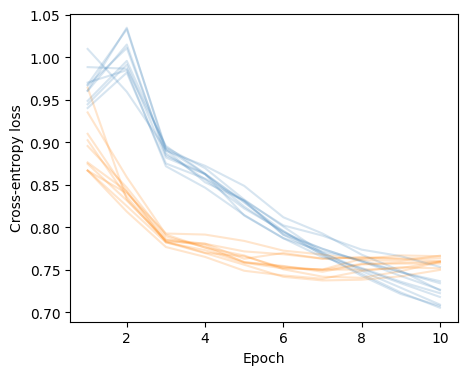

In [46]:
result(DNN, 10, 'none')

### PGR

------------------------------ 
Test set:
epsilon = 0.001   | regularity = 0.757 (0.154)
epsilon = 0.0001  | regularity = 0.713 (0.168)
epsilon = 0       | regularity = 0.706 (0.169)
epsilon = -0.0001 | regularity = 0.692 (0.170)
epsilon = -0.001  | regularity = 0.617 (0.175)
------------------------------
Penalty = 100
------------------------------
Model 1 
Training set:   LL = -582.6 | acc = 68.4% | F1 = 55.5%
Validation set: LL = -155.3 | acc = 68.0% | F1 = 55.0%
Test set:       LL = -385.8 | acc = 66.6% | F1 = 53.2%
Model 2 
Training set:   LL = -568.8 | acc = 68.4% | F1 = 55.5%
Validation set: LL = -153.1 | acc = 68.0% | F1 = 55.0%
Test set:       LL = -381.7 | acc = 66.6% | F1 = 53.2%
Model 3 
Training set:   LL = -585.4 | acc = 68.4% | F1 = 55.5%
Validation set: LL = -153.8 | acc = 68.0% | F1 = 55.0%
Test set:       LL = -386.8 | acc = 66.6% | F1 = 53.2%
Model 4 
Training set:   LL = -585.9 | acc = 68.4% | F1 = 55.5%
Validation set: LL = -151.1 | acc = 68.0% | F1 = 55.0%
Test s

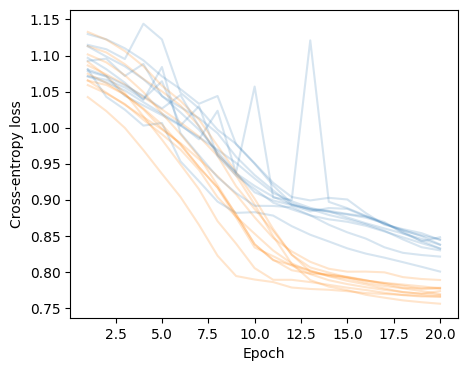

------------------------------ 
Test set:
epsilon = 0.001   | regularity = 1.000 (0.000)
epsilon = 0.0001  | regularity = 1.000 (0.001)
epsilon = 0       | regularity = 1.000 (0.001)
epsilon = -0.0001 | regularity = 1.000 (0.001)
epsilon = -0.001  | regularity = 0.995 (0.003)
------------------------------
Penalty = 10
------------------------------
Model 1 
Training set:   LL = -505.8 | acc = 73.5% | F1 = 70.5%
Validation set: LL = -149.3 | acc = 68.0% | F1 = 64.9%
Test set:       LL = -377.2 | acc = 71.4% | F1 = 67.5%
Model 2 
Training set:   LL = -503.9 | acc = 74.6% | F1 = 69.7%
Validation set: LL = -146.5 | acc = 67.5% | F1 = 61.2%
Test set:       LL = -369.7 | acc = 69.8% | F1 = 63.4%
Model 3 
Training set:   LL = -506.3 | acc = 74.4% | F1 = 70.6%
Validation set: LL = -147.0 | acc = 66.0% | F1 = 61.0%
Test set:       LL = -371.2 | acc = 71.8% | F1 = 67.0%
Model 4 
Training set:   LL = -506.1 | acc = 74.0% | F1 = 69.1%
Validation set: LL = -146.4 | acc = 67.0% | F1 = 62.2%
Test se

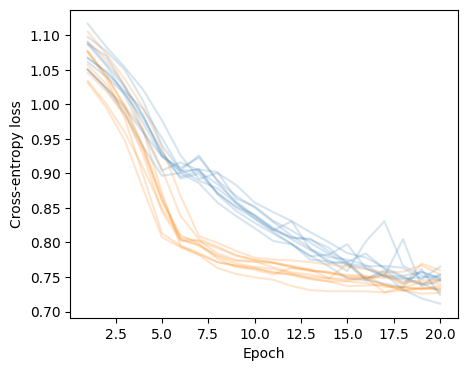

------------------------------ 
Test set:
epsilon = 0.001   | regularity = 1.000 (0.000)
epsilon = 0.0001  | regularity = 1.000 (0.000)
epsilon = 0       | regularity = 1.000 (0.000)
epsilon = -0.0001 | regularity = 0.998 (0.001)
epsilon = -0.001  | regularity = 0.981 (0.007)
------------------------------
Penalty = 1
------------------------------
Model 1 
Training set:   LL = -514.8 | acc = 72.8% | F1 = 67.6%
Validation set: LL = -149.5 | acc = 69.5% | F1 = 65.1%
Test set:       LL = -376.0 | acc = 70.6% | F1 = 65.6%
Model 2 
Training set:   LL = -513.4 | acc = 72.6% | F1 = 66.5%
Validation set: LL = -146.9 | acc = 68.0% | F1 = 61.5%
Test set:       LL = -370.1 | acc = 68.6% | F1 = 61.0%
Model 3 
Training set:   LL = -508.0 | acc = 73.4% | F1 = 68.8%
Validation set: LL = -145.5 | acc = 68.5% | F1 = 62.6%
Test set:       LL = -366.4 | acc = 70.2% | F1 = 64.5%
Model 4 
Training set:   LL = -511.1 | acc = 73.0% | F1 = 67.6%
Validation set: LL = -145.3 | acc = 69.5% | F1 = 65.2%
Test set

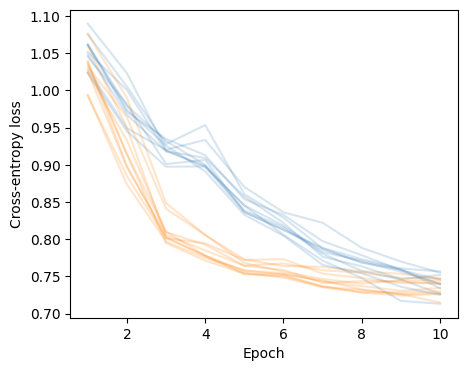

------------------------------ 
Test set:
epsilon = 0.001   | regularity = 1.000 (0.001)
epsilon = 0.0001  | regularity = 0.999 (0.001)
epsilon = 0       | regularity = 0.998 (0.004)
epsilon = -0.0001 | regularity = 0.994 (0.005)
epsilon = -0.001  | regularity = 0.965 (0.015)
------------------------------
Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -489.7 | acc = 75.2% | F1 = 72.7%
Validation set: LL = -149.2 | acc = 69.0% | F1 = 65.4%
Test set:       LL = -375.0 | acc = 70.6% | F1 = 66.8%
Model 2 
Training set:   LL = -481.6 | acc = 75.2% | F1 = 72.9%
Validation set: LL = -145.0 | acc = 70.0% | F1 = 67.2%
Test set:       LL = -365.7 | acc = 71.0% | F1 = 67.9%
Model 3 
Training set:   LL = -480.4 | acc = 75.9% | F1 = 73.8%
Validation set: LL = -146.3 | acc = 67.5% | F1 = 64.8%
Test set:       LL = -365.5 | acc = 72.4% | F1 = 69.7%
Model 4 
Training set:   LL = -485.5 | acc = 75.4% | F1 = 73.3%
Validation set: LL = -147.1 | acc = 69.0% | F1 = 66.7%
Test s

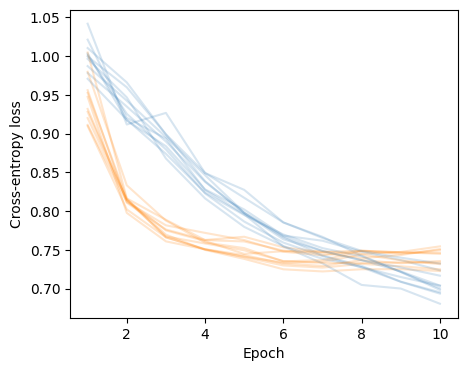

------------------------------ 
Test set:
epsilon = 0.001   | regularity = 1.000 (0.001)
epsilon = 0.0001  | regularity = 0.998 (0.004)
epsilon = 0       | regularity = 0.997 (0.004)
epsilon = -0.0001 | regularity = 0.991 (0.005)
epsilon = -0.001  | regularity = 0.963 (0.014)
------------------------------
Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -490.7 | acc = 74.1% | F1 = 69.5%
Validation set: LL = -149.9 | acc = 68.5% | F1 = 63.7%
Test set:       LL = -375.1 | acc = 71.2% | F1 = 66.8%
Model 2 
Training set:   LL = -484.9 | acc = 73.9% | F1 = 68.6%
Validation set: LL = -147.9 | acc = 68.5% | F1 = 62.7%
Test set:       LL = -369.6 | acc = 70.2% | F1 = 64.0%
Model 3 
Training set:   LL = -488.4 | acc = 73.9% | F1 = 68.6%
Validation set: LL = -149.3 | acc = 67.5% | F1 = 62.1%
Test set:       LL = -369.2 | acc = 70.4% | F1 = 64.4%
Model 4 
Training set:   LL = -490.5 | acc = 74.6% | F1 = 69.7%
Validation set: LL = -148.2 | acc = 68.5% | F1 = 64.5%
Test 

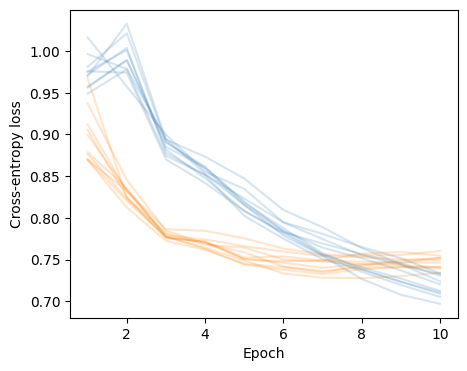

------------------------------ 
Test set:
epsilon = 0.001   | regularity = 0.981 (0.015)
epsilon = 0.0001  | regularity = 0.964 (0.020)
epsilon = 0       | regularity = 0.964 (0.020)
epsilon = -0.0001 | regularity = 0.955 (0.020)
epsilon = -0.001  | regularity = 0.917 (0.022)
------------------------------
Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -493.5 | acc = 74.4% | F1 = 69.4%
Validation set: LL = -152.0 | acc = 68.5% | F1 = 63.2%
Test set:       LL = -375.8 | acc = 70.4% | F1 = 64.9%
Model 2 
Training set:   LL = -485.6 | acc = 73.9% | F1 = 68.7%
Validation set: LL = -149.9 | acc = 67.5% | F1 = 62.0%
Test set:       LL = -371.9 | acc = 70.0% | F1 = 63.8%
Model 3 
Training set:   LL = -491.8 | acc = 74.0% | F1 = 68.7%
Validation set: LL = -150.9 | acc = 67.0% | F1 = 61.7%
Test set:       LL = -370.9 | acc = 70.2% | F1 = 64.2%
Model 4 
Training set:   LL = -492.8 | acc = 74.4% | F1 = 69.3%
Validation set: LL = -150.5 | acc = 68.5% | F1 = 63.4%
Test

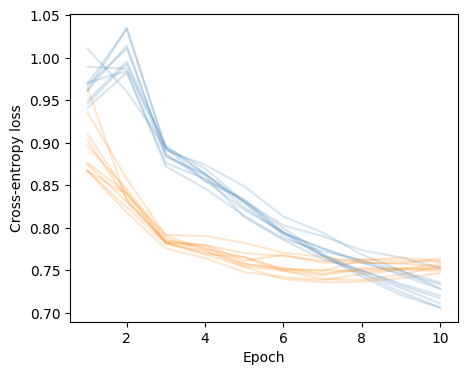

------------------------------ 
Test set:
epsilon = 0.001   | regularity = 0.880 (0.079)
epsilon = 0.0001  | regularity = 0.846 (0.091)
epsilon = 0       | regularity = 0.842 (0.092)
epsilon = -0.0001 | regularity = 0.831 (0.092)
epsilon = -0.001  | regularity = 0.759 (0.101)
------------------------------
Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -493.9 | acc = 74.4% | F1 = 69.5%
Validation set: LL = -152.9 | acc = 68.0% | F1 = 62.8%
Test set:       LL = -377.1 | acc = 70.4% | F1 = 65.0%
Model 2 
Training set:   LL = -486.3 | acc = 74.5% | F1 = 69.4%
Validation set: LL = -150.3 | acc = 67.5% | F1 = 62.1%
Test set:       LL = -373.0 | acc = 70.4% | F1 = 64.4%
Model 3 
Training set:   LL = -492.4 | acc = 73.9% | F1 = 68.6%
Validation set: LL = -151.7 | acc = 67.5% | F1 = 62.4%
Test set:       LL = -373.3 | acc = 70.4% | F1 = 64.4%
Model 4 
Training set:   LL = -493.0 | acc = 74.1% | F1 = 69.1%
Validation set: LL = -151.7 | acc = 68.5% | F1 = 63.5%
Tes

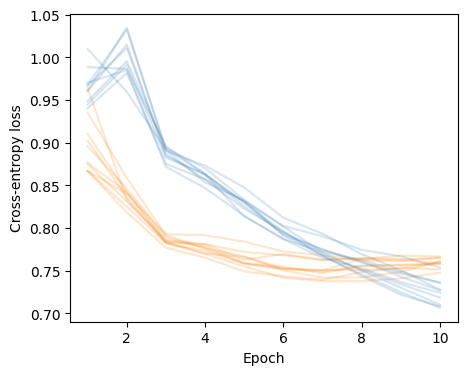

------------------------------ 
Test set:
epsilon = 0.001   | regularity = 0.773 (0.145)
epsilon = 0.0001  | regularity = 0.730 (0.153)
epsilon = 0       | regularity = 0.722 (0.156)
epsilon = -0.0001 | regularity = 0.709 (0.157)
epsilon = -0.001  | regularity = 0.635 (0.162)
------------------------------
Model comparison:


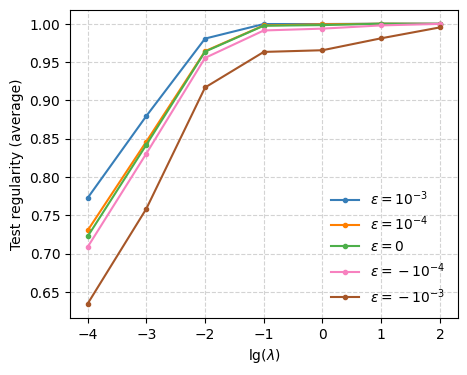

In [47]:
# With sum
result(DNN, 10, 'PGR', [10**i for i in range(2, -5, -1)])

## TasteNet
A flexible NN-based choice model proposed by [Han et al. (2022)](https://doi.org/10.1016/j.trb.2022.07.001). Here is a special case that learns all $\beta$'s from TasteNet.

In [48]:
class TasteNet(nn.Module):
    'Class of TasteNet'
    def __init__(self):
        super(TasteNet, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(8, 100),
            nn.ReLU(),
            nn.Linear(100, 7)
        )

    def forward(self, x):
        'Function to specify utilities using TasteNet parameters'
        betas = self.seq(x[:, :8])
        V1 = betas[:, 0] * torch.ones(len(x)) + torch.sum(betas[:, 1:3] * x[:, 8:10], dim=1)
        V2 = betas[:, 3] * torch.ones(len(x)) + torch.sum(betas[:, 4:6] * x[:, 10:12], dim=1)
        V3 = betas[:, 6] * x[:, 12]
        return torch.stack((V1, V2, V3), dim=1)

### Without GR

Penalty = 0
------------------------------
Model 1 
Training set:   LL = -557.3 | acc = 69.9% | F1 = 61.1%
Validation set: LL = -159.1 | acc = 67.0% | F1 = 57.5%
Test set:       LL = -392.4 | acc = 69.6% | F1 = 61.5%
Model 2 
Training set:   LL = -554.7 | acc = 71.6% | F1 = 64.7%
Validation set: LL = -162.8 | acc = 68.5% | F1 = 60.7%
Test set:       LL = -390.8 | acc = 70.0% | F1 = 62.0%
Model 3 
Training set:   LL = -556.3 | acc = 70.4% | F1 = 62.0%
Validation set: LL = -160.6 | acc = 67.5% | F1 = 57.5%
Test set:       LL = -388.9 | acc = 69.2% | F1 = 60.0%
Model 4 
Training set:   LL = -555.6 | acc = 71.6% | F1 = 64.1%
Validation set: LL = -158.9 | acc = 67.0% | F1 = 57.9%
Test set:       LL = -392.7 | acc = 69.8% | F1 = 61.1%
Model 5 
Training set:   LL = -563.0 | acc = 71.5% | F1 = 64.2%
Validation set: LL = -158.0 | acc = 68.0% | F1 = 61.7%
Test set:       LL = -389.9 | acc = 70.8% | F1 = 63.5%
Model 6 
Training set:   LL = -558.4 | acc = 71.2% | F1 = 63.2%
Validation set: LL = -1

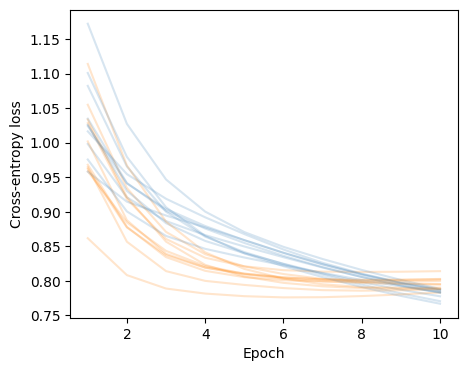

------------------------------ 
Test set:
epsilon = 0.001   | regularity = 0.696 (0.126)
epsilon = 0.0001  | regularity = 0.678 (0.126)
epsilon = 0       | regularity = 0.672 (0.127)
epsilon = -0.0001 | regularity = 0.666 (0.129)
epsilon = -0.001  | regularity = 0.639 (0.128)
------------------------------


In [49]:
result(TasteNet, 10, 'none')

### PGR

Penalty = 1
------------------------------
Model 1 
Training set:   LL = -649.2 | acc = 67.8% | F1 = 55.6%
Validation set: LL = -166.1 | acc = 66.5% | F1 = 55.1%
Test set:       LL = -409.7 | acc = 65.4% | F1 = 53.0%
Model 2 
Training set:   LL = -608.5 | acc = 68.4% | F1 = 55.8%
Validation set: LL = -157.3 | acc = 67.0% | F1 = 54.6%
Test set:       LL = -389.4 | acc = 66.6% | F1 = 53.2%
Model 3 
Training set:   LL = -702.7 | acc = 65.5% | F1 = 55.0%
Validation set: LL = -179.5 | acc = 65.5% | F1 = 54.9%
Test set:       LL = -433.8 | acc = 64.6% | F1 = 53.0%
Model 4 
Training set:   LL = -624.4 | acc = 68.4% | F1 = 55.5%
Validation set: LL = -156.7 | acc = 67.5% | F1 = 54.8%
Test set:       LL = -400.8 | acc = 66.6% | F1 = 53.2%
Model 5 
Training set:   LL = -623.6 | acc = 68.5% | F1 = 55.8%
Validation set: LL = -156.9 | acc = 67.5% | F1 = 55.0%
Test set:       LL = -401.5 | acc = 66.6% | F1 = 53.2%
Model 6 
Training set:   LL = -633.3 | acc = 68.2% | F1 = 55.7%
Validation set: LL = -1

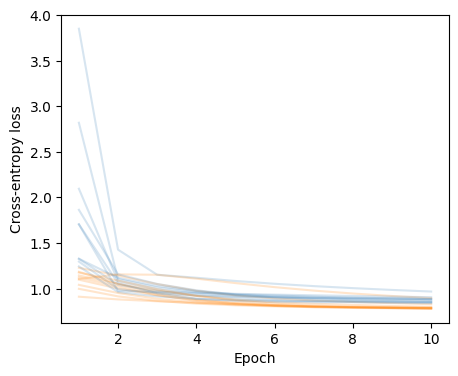

------------------------------ 
Test set:
epsilon = 0.001   | regularity = 1.000 (0.001)
epsilon = 0.0001  | regularity = 0.998 (0.002)
epsilon = 0       | regularity = 0.998 (0.003)
epsilon = -0.0001 | regularity = 0.997 (0.003)
epsilon = -0.001  | regularity = 0.985 (0.018)
------------------------------
Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -588.4 | acc = 68.6% | F1 = 56.1%
Validation set: LL = -154.6 | acc = 67.5% | F1 = 54.8%
Test set:       LL = -388.6 | acc = 66.6% | F1 = 53.2%
Model 2 
Training set:   LL = -570.8 | acc = 69.2% | F1 = 58.1%
Validation set: LL = -158.5 | acc = 69.0% | F1 = 58.7%
Test set:       LL = -384.1 | acc = 68.6% | F1 = 58.2%
Model 3 
Training set:   LL = -588.5 | acc = 68.4% | F1 = 55.5%
Validation set: LL = -157.7 | acc = 67.5% | F1 = 54.8%
Test set:       LL = -386.3 | acc = 66.6% | F1 = 53.2%
Model 4 
Training set:   LL = -579.8 | acc = 68.6% | F1 = 56.1%
Validation set: LL = -155.7 | acc = 67.5% | F1 = 55.0%
Test s

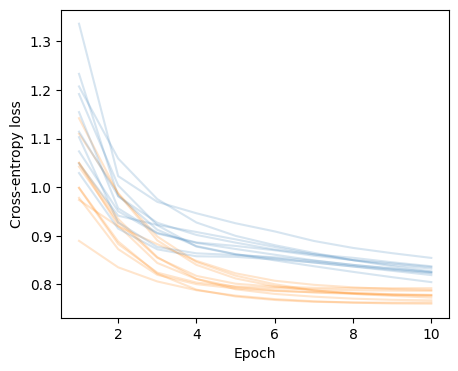

------------------------------ 
Test set:
epsilon = 0.001   | regularity = 0.999 (0.002)
epsilon = 0.0001  | regularity = 0.995 (0.005)
epsilon = 0       | regularity = 0.994 (0.006)
epsilon = -0.0001 | regularity = 0.991 (0.008)
epsilon = -0.001  | regularity = 0.961 (0.022)
------------------------------
Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -561.7 | acc = 69.4% | F1 = 59.0%
Validation set: LL = -154.2 | acc = 68.0% | F1 = 57.4%
Test set:       LL = -384.0 | acc = 69.2% | F1 = 59.3%
Model 2 
Training set:   LL = -558.0 | acc = 70.5% | F1 = 61.8%
Validation set: LL = -159.6 | acc = 68.0% | F1 = 58.9%
Test set:       LL = -383.0 | acc = 69.6% | F1 = 60.8%
Model 3 
Training set:   LL = -560.4 | acc = 69.8% | F1 = 59.5%
Validation set: LL = -157.7 | acc = 66.5% | F1 = 54.5%
Test set:       LL = -382.4 | acc = 68.4% | F1 = 57.5%
Model 4 
Training set:   LL = -559.9 | acc = 70.9% | F1 = 61.7%
Validation set: LL = -156.3 | acc = 66.5% | F1 = 56.1%
Test 

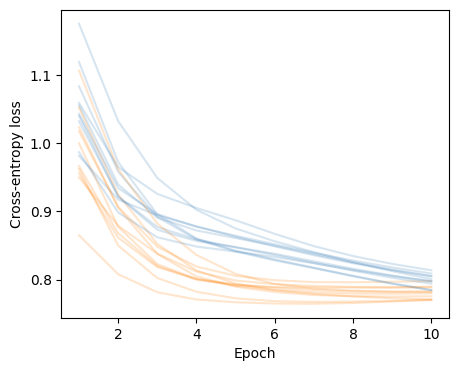

------------------------------ 
Test set:
epsilon = 0.001   | regularity = 0.995 (0.007)
epsilon = 0.0001  | regularity = 0.984 (0.014)
epsilon = 0       | regularity = 0.981 (0.014)
epsilon = -0.0001 | regularity = 0.977 (0.015)
epsilon = -0.001  | regularity = 0.947 (0.027)
------------------------------
Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -555.7 | acc = 69.6% | F1 = 60.1%
Validation set: LL = -157.8 | acc = 67.5% | F1 = 57.4%
Test set:       LL = -388.8 | acc = 69.4% | F1 = 60.7%
Model 2 
Training set:   LL = -554.4 | acc = 71.1% | F1 = 63.6%
Validation set: LL = -161.8 | acc = 68.0% | F1 = 59.7%
Test set:       LL = -387.8 | acc = 69.8% | F1 = 61.3%
Model 3 
Training set:   LL = -555.0 | acc = 70.5% | F1 = 61.9%
Validation set: LL = -159.6 | acc = 67.5% | F1 = 57.5%
Test set:       LL = -386.2 | acc = 69.4% | F1 = 59.9%
Model 4 
Training set:   LL = -555.1 | acc = 71.4% | F1 = 63.1%
Validation set: LL = -158.0 | acc = 66.5% | F1 = 57.0%
Test

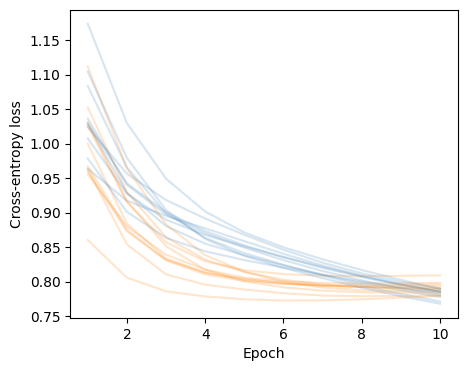

------------------------------ 
Test set:
epsilon = 0.001   | regularity = 0.834 (0.070)
epsilon = 0.0001  | regularity = 0.811 (0.070)
epsilon = 0       | regularity = 0.809 (0.071)
epsilon = -0.0001 | regularity = 0.806 (0.072)
epsilon = -0.001  | regularity = 0.779 (0.072)
------------------------------
Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -557.1 | acc = 70.0% | F1 = 61.1%
Validation set: LL = -158.9 | acc = 67.0% | F1 = 57.5%
Test set:       LL = -391.9 | acc = 69.8% | F1 = 61.6%
Model 2 
Training set:   LL = -554.6 | acc = 71.5% | F1 = 64.5%
Validation set: LL = -162.7 | acc = 68.5% | F1 = 60.7%
Test set:       LL = -390.4 | acc = 70.0% | F1 = 62.0%
Model 3 
Training set:   LL = -556.1 | acc = 70.5% | F1 = 62.2%
Validation set: LL = -160.5 | acc = 67.5% | F1 = 57.5%
Test set:       LL = -388.5 | acc = 69.4% | F1 = 60.2%
Model 4 
Training set:   LL = -555.5 | acc = 71.6% | F1 = 63.9%
Validation set: LL = -158.8 | acc = 67.0% | F1 = 57.9%
Tes

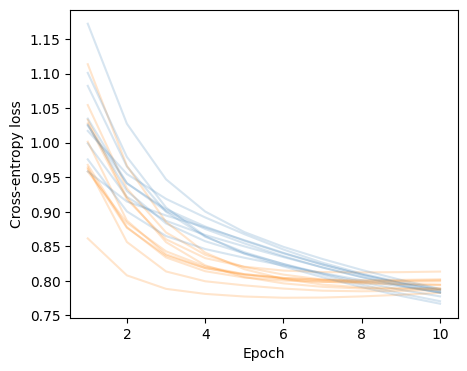

------------------------------ 
Test set:
epsilon = 0.001   | regularity = 0.710 (0.119)
epsilon = 0.0001  | regularity = 0.688 (0.123)
epsilon = 0       | regularity = 0.687 (0.122)
epsilon = -0.0001 | regularity = 0.684 (0.122)
epsilon = -0.001  | regularity = 0.654 (0.122)
------------------------------
Penalty = 1e-05
------------------------------
Model 1 
Training set:   LL = -557.3 | acc = 69.9% | F1 = 61.1%
Validation set: LL = -159.1 | acc = 67.0% | F1 = 57.5%
Test set:       LL = -392.3 | acc = 69.6% | F1 = 61.5%
Model 2 
Training set:   LL = -554.7 | acc = 71.6% | F1 = 64.7%
Validation set: LL = -162.8 | acc = 68.5% | F1 = 60.7%
Test set:       LL = -390.7 | acc = 70.0% | F1 = 62.0%
Model 3 
Training set:   LL = -556.3 | acc = 70.4% | F1 = 62.0%
Validation set: LL = -160.5 | acc = 67.5% | F1 = 57.5%
Test set:       LL = -388.9 | acc = 69.4% | F1 = 60.2%
Model 4 
Training set:   LL = -555.6 | acc = 71.6% | F1 = 64.1%
Validation set: LL = -158.9 | acc = 67.0% | F1 = 57.9%
Test

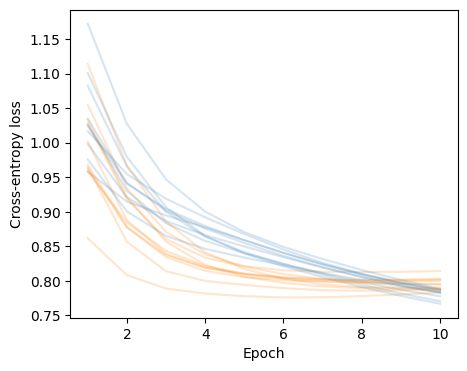

------------------------------ 
Test set:
epsilon = 0.001   | regularity = 0.699 (0.125)
epsilon = 0.0001  | regularity = 0.678 (0.126)
epsilon = 0       | regularity = 0.676 (0.125)
epsilon = -0.0001 | regularity = 0.670 (0.125)
epsilon = -0.001  | regularity = 0.640 (0.127)
------------------------------
Penalty = 1e-06
------------------------------
Model 1 
Training set:   LL = -557.3 | acc = 69.9% | F1 = 61.1%
Validation set: LL = -159.1 | acc = 67.0% | F1 = 57.5%
Test set:       LL = -392.4 | acc = 69.6% | F1 = 61.5%
Model 2 
Training set:   LL = -554.7 | acc = 71.6% | F1 = 64.7%
Validation set: LL = -162.8 | acc = 68.5% | F1 = 60.7%
Test set:       LL = -390.8 | acc = 70.0% | F1 = 62.0%
Model 3 
Training set:   LL = -556.3 | acc = 70.4% | F1 = 62.0%
Validation set: LL = -160.6 | acc = 67.5% | F1 = 57.5%
Test set:       LL = -388.9 | acc = 69.2% | F1 = 60.0%
Model 4 
Training set:   LL = -555.6 | acc = 71.6% | F1 = 64.1%
Validation set: LL = -158.9 | acc = 67.0% | F1 = 57.9%
Test

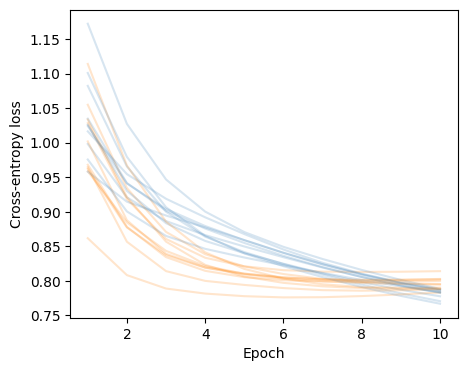

------------------------------ 
Test set:
epsilon = 0.001   | regularity = 0.696 (0.126)
epsilon = 0.0001  | regularity = 0.678 (0.126)
epsilon = 0       | regularity = 0.673 (0.128)
epsilon = -0.0001 | regularity = 0.666 (0.129)
epsilon = -0.001  | regularity = 0.639 (0.128)
------------------------------
Model comparison:


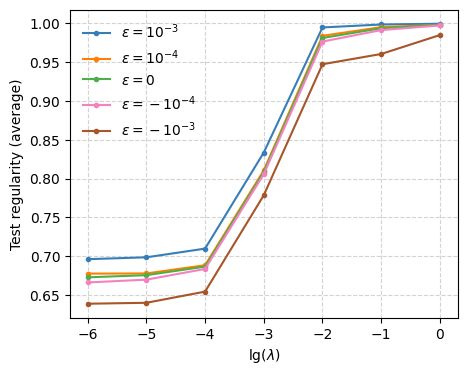

In [50]:
result(TasteNet, 10, 'PGR', [10**i for i in range(0, -7, -1)])